In [6]:
from nltk.corpus import treebank, ptb
from collections import Counter
import nltk
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_pickle_file = '/misc/vlgscratch4/BrunaGroup/rj1408/nlu/ptb_wsj_pos/train.p'
val_pickle_file = '/misc/vlgscratch4/BrunaGroup/rj1408/nlu/ptb_wsj_pos/val.p'
test_pickle_file = '/misc/vlgscratch4/BrunaGroup/rj1408/nlu/ptb_wsj_pos/test.p'

with open(train_pickle_file,"rb") as f:
    traindict = pkl.load(f)
with open(val_pickle_file,"rb") as f:
    valdict = pkl.load(f)
with open(test_pickle_file,"rb") as f:
    testdict = pkl.load(f)

In [3]:
#tag analysis
with open('tagset.txt') as f:
    alltags = f.read()
    alltags = set(alltags.split('\n'))

In [4]:
lis = traindict['tagged_words']
tag_cntr = {}
for tup in lis:
    if tup[1] in alltags:
        if tup[1] not in tag_cntr:
            tag_cntr[tup[1]] = Counter()
        tag_cntr[tup[1]][tup[0]] += 1

In [5]:
#vocab size for each tag
tag_vocabsize = Counter(dict([(tup[0], len(tup[1])) for tup in tag_cntr.items()]))
tag_vocabsize.most_common()

[('NNP', 11127),
 ('NN', 9149),
 ('JJ', 7958),
 ('NNS', 4872),
 ('CD', 4597),
 ('VBN', 2089),
 ('VB', 2056),
 ('VBG', 1987),
 ('VBD', 1560),
 ('RB', 1283),
 ('VBZ', 1123),
 ('VBP', 975),
 ('-NONE-', 604),
 ('NNPS', 562),
 ('IN', 187),
 ('JJR', 151),
 ('JJS', 103),
 ('FW', 101),
 ('RBR', 51),
 ('DT', 48),
 ('PRP', 46),
 ('UH', 39),
 ('RP', 35),
 ('CC', 33),
 ('MD', 27),
 ('LS', 18),
 ('PRP$', 15),
 ('SYM', 15),
 ('WRB', 14),
 ('PDT', 13),
 ('WDT', 12),
 ('$', 9),
 ('WP', 8),
 ('RBS', 8),
 (',', 5),
 (':', 5),
 ('TO', 4),
 ('.', 3),
 ('POS', 3),
 ('``', 3),
 ('EX', 2),
 ("''", 2),
 ('-LRB-', 2),
 ('-RRB-', 2),
 ('WP$', 1),
 ('#', 1)]

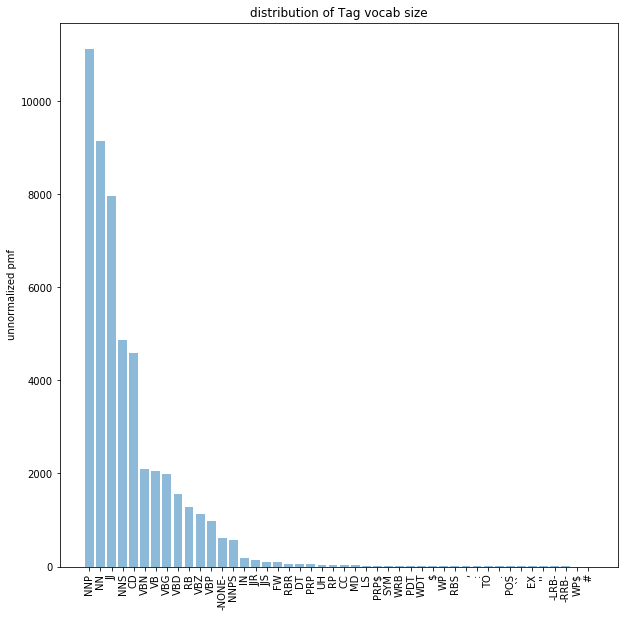

In [11]:
cntr = tag_vocabsize.most_common()
objects = [tup[0] for tup in cntr]
y_pos = np.arange(len(objects))
performance = [tup[1] for tup in cntr]

plt.figure(figsize=(10,10))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.ylabel('unnormalized pmf')
plt.title('distribution of Tag vocab size')
plt.savefig('../plots/tagpdf.png')
plt.show()

In [26]:
#Average number of tokens in a tag
sum([tup[1] for tup in tag_vocabsize.items()])/len(tag_vocabsize.items())

1106.695652173913

In [15]:
tokcntr = {}
for tup in traindict['tagged_words']:
    if tup[0] not in tokcntr:
        tokcntr[tup[0]] = set()
    tokcntr[tup[0]].add(tup[1])

In [29]:
toksizecntr = Counter(dict([(tup[0], len(tup[1]))for tup in tokcntr.items()]))
sum([tup[1] for tup in toksizecntr.items()])/len(toksizecntr.items())

1.161938237509415

In [16]:
fulltags = set([tup[1] for tup in traindict['tagged_words']])
punctags = fulltags.difference(alltags)
punctoks = [tag_cntr[tag].keys() for tag in punctags]
punctoks = set([tok for lis in punctoks for tok in lis])

In [17]:
vocab_cntr = Counter([tup[0] for tup in  lis])

In [20]:
len(vocab_cntr)

43813

In [21]:
#sent len analysis
sentlens = Counter([len(sent) for sent in traindict['tagged_sents']]).most_common()

num = sum([tup[1] for tup in sentlens if tup[0] <= 60])
den = len(traindict['tagged_sents'])
num/den

0.9921243360632146

In [23]:
def getPercentile(voc_cntr, topk):
    totalsize = sum([tup[1] for tup in voc_cntr.items()])
    topksize = sum([tup[1] for tup in voc_cntr.most_common(topk)])
    return topksize/totalsize

In [26]:
getPercentile(vocab_cntr, 15000)

0.9592498465492572